# InteractomeSignatures

This notebook creates Figure 5, related to Interactome Signatures.

Please visit the [interactome-signatures](https://github.com/ligand-discovery/interactome-signatures) repository for detailed information on how to generate the figures related to this notebook.

In [2]:
import pandas as pd
import joblib
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import stylia
from stylia import TWO_COLUMNS_WIDTH
from stylia.colors import ContinuousColorMap

#base_results_path = "/Users/mduranfrigola/Documents/GitHub/interactome-signatures/results/"
base_results_path = "/path/to/interactome-signatures/results"
results_path = os.path.join(base_results_path, "topwiz_maxpxf100_minp4_maxp40")

In [6]:
def tokenizer(x):
    return x.split(" ")

topic_data = joblib.load(os.path.join(results_path, "topic_data.joblib"))
processed_topicwizard_data = joblib.load(os.path.join(results_path, "processed_topicwizard_data.joblib"))

topic_names = topic_data["topic_names"]

df = pd.read_csv(os.path.join(results_path, "FragmentHasTopic.csv"))

cmap = ContinuousColorMap()
cmap.fit([i for i in range(len(topic_names))])
topic_colors = cmap.transform([i for i in range(len(topic_names))])

/Users/mduranfrigola/miniconda3/envs/bdfigs/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mduranfrigola/miniconda3/envs/bdfigs/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator NMF from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


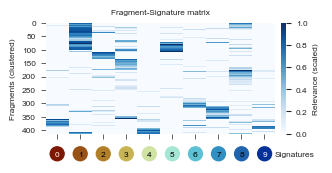

In [48]:
import random
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

fig, axs = stylia.create_figure(2, 1, width=TWO_COLUMNS_WIDTH*0.8*(3/5.2), height=TWO_COLUMNS_WIDTH/4.2, height_ratios=[6,1])

ax = axs.next()

W = processed_topicwizard_data["document_topic_matrix"]

W = sklearn.preprocessing.MinMaxScaler().fit_transform(W)
W[W < 0.1] = 0

ax.set_yticks([i for i in range(len(topic_names))])
ax.set_ylim(len(topic_names), -1)

Z = hierarchy.ward(W)
hierarchy.leaves_list(Z)
clustered_idxs = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, W))

sns.heatmap(W[clustered_idxs], ax=ax, cmap="Blues", cbar_kws={'label': "Relevance (scaled)", "pad": 0.02})
yticks = [0, 50, 100, 150, 200, 250, 300, 350, 400]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xticks([i+0.5 for i in range(len(topic_names))])
ax.set_xticklabels("")

stylia.label(ax=ax, title="Fragment-Signature matrix", ylabel="Fragments (clustered)", xlabel="")

ax = axs.next()

topic_importances = processed_topicwizard_data["topic_importances"]
ax.scatter([i for i in range(len(topic_importances))], [0]*len(topic_importances), s=100, color=topic_colors)
for i in range(len(topic_importances)):
    if i == 0 or i == 9:
        c = "white"
    else:
        c = "black"
    ax.text(i, 0, i, ha="center", va="center", fontsize=6, color=c)
ax.set_axis_off()
ax.set_xlim(-0.5, 11.5)

ax.text(10.3, 0, "Signatures", ha="center", va="center", fontsize=6)

stylia.label(ax=ax, title="", xlabel="", ylabel="", abc="")

stylia.save_figure("../assets/Figure05_B.png")
stylia.save_figure("../assets/Figure05_B.pdf")

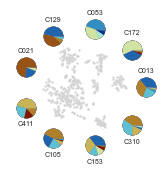

In [76]:
fig, axs = stylia.create_figure(1, 1, width=TWO_COLUMNS_WIDTH*1*(1.2/5.2), height=TWO_COLUMNS_WIDTH/5*1.2)

do_label = False

fids = topic_data["document_names"]

num_fragments = 9

#sel_fids = random.sample(fids, num_fragments)
sel_fids = ["C013", "C172", "C053", "C129", "C021", "C411", "C105", "C153", "C310"]
sel_fids_idxs = [fids.index(f) for f in sel_fids]
phis = np.linspace(0, 2*np.pi, num_fragments+1)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

    markers = []
    previous = 0
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 100)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 100)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color, 'lw':0})

    for marker in markers:
        ax.scatter(xs, ys, **marker, zorder=10000)
        ax.scatter(xs, ys, color="gray", s=200, lw=0)

S = np.array([list(pol2cart(1.5, phi)) for phi in phis])

ax = axs.next()
P = np.array(df[["proj_x", "proj_y"]])
P = MinMaxScaler(feature_range=(-1,1)).fit_transform(P)
ax.scatter(P[:,0], P[:,1], color="lightgray", s=0.5)
ax.scatter(S[:,0], S[:,1])

if do_label:
    for fidx in sel_fids_idxs:
        ax.text(P[fidx, 0], P[fidx, 1], fids[fidx])

W = processed_topicwizard_data["document_topic_matrix"]
for i in range(S.shape[0]-1):
    r = S[i]
    v = W[i,:]
    v = v / np.sum(v)
    v = v*1000
    np.floor(v)
    v = v/1000
    v = v*0.99
    idxs = np.argsort(v)[::-1]
    v = [v[i] for i in idxs]
    c = [topic_colors[i] for i in idxs]
    drawPieMarker([r[0]], [r[1]], v, sizes=[200], colors=c, ax=ax)
    if r[1] >= 0:
        dl = 0.42
    else:
        dl = -0.42
    ax.text(r[0], r[1] + dl, sel_fids[i], va="center", ha="center")
    
ax.grid(False)
ax.set_axis_off()
ax.set_xlim(-1.8,1.8)
ax.set_ylim(-1.8,1.8)
stylia.label(ax=ax, title="", xlabel="", ylabel="")

if do_label:
    sufix = "_label"
else:
    sufix = ""
stylia.save_figure("../assets/Figure05_C{0}.png".format(sufix))
stylia.save_figure("../assets/Figure05_C{0}.pdf".format(sufix))

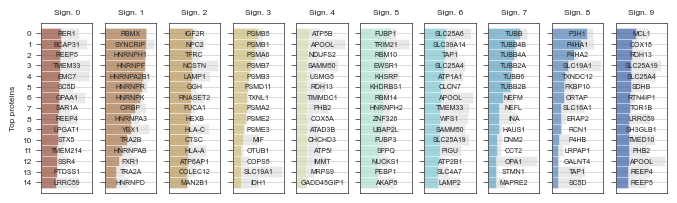

In [118]:
import matplotlib.pyplot as plt

def topic_has_protein_barplot(ax, i, num_proteins=15):
    topic_name = "Topic {0}".format(i)
    pht = pd.read_csv(os.path.join(results_path, "ProteinHasTopic.csv"))
    pht = pht.sort_values(by=topic_name, ascending=False).head(num_proteins)
    vals = np.array(pht[topic_name])
    gvals = np.array(pht["importance"])
    idxs = [i for i in range(num_proteins)]
    ax.barh(idxs, gvals, lw=0.5, color="lightgray", height=1, alpha=0.5, edgecolor="white")
    ax.barh(idxs, vals, lw=0.5, color=topic_colors[topic_names.index(topic_name)], height=1, alpha=0.5, edgecolor="white")
    xlim = ax.get_xlim()
    ax.set_ylim(len(vals), -1)
    ax.set_title(topic_name.replace("Topic", "Sign."))
    ax.set_yticks([i for i in range(num_proteins)])
    if topic_name == "Topic 0":
        ax.set_ylabel("Top proteins")
    else:
        ax.set_yticklabels("")
        ax.set_ylabel("")
    for i, l in enumerate(pht["gene_name"].tolist()):
        ax.text(xlim[1]*0.5, i, l, ha="center", va="center")
    #ax.set_yticklabels(pht["gene_name"])
    ax.set_xlabel("")
    ax.set_xticks([])
    
    
fig, axs = stylia.create_figure(1, 10, width=TWO_COLUMNS_WIDTH*0.948, height=TWO_COLUMNS_WIDTH*0.28)
for i in range(10):
    ax = axs.next()
    topic_has_protein_barplot(ax, i)
plt.tight_layout()

stylia.save_figure("../assets/Figure05_D.png")
stylia.save_figure("../assets/Figure05_D.pdf")

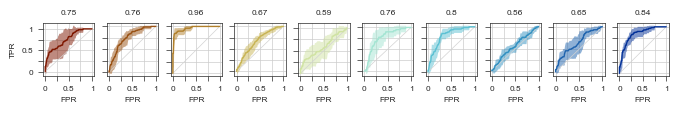

In [97]:
def roc_plot(ax, topic_name, sufix=40):
    x = np.arange(0,1.01,0.01)
    mdl_validation_metrics = joblib.load(os.path.join(results_path, "modeling_validations", "validation_metrics.joblib".format(sufix)))
    idx = topic_names.index(topic_name)
    results = mdl_validation_metrics[idx]
    n_splits = results["n_splits"]
    ys = []
    for i in range(n_splits):
        fpr = results["fprs"][i]
        tpr = results["tprs"][i]
        ys += [np.interp(x, fpr, tpr)]
    ys = np.array(ys)
    y_mean = np.array([0] + list(np.mean(ys, axis=0)))
    y_std = np.array([0] + list(np.std(ys, axis=0)))
    x = np.array([0] + list(x))
    ax.plot(x, y_mean, zorder=1000, color=topic_colors[idx], lw=1)
    ax.fill_between(x, y_mean+y_std, y_mean-y_std, color=topic_colors[idx], alpha=0.5, lw=0)
    ax.plot([0,1], [0,1], lw=0.5, color="lightgray")
    return np.mean(results["aucs"])

fig, axs = stylia.create_figure(1, 10, width=TWO_COLUMNS_WIDTH*0.95, height=TWO_COLUMNS_WIDTH*0.18*0.85)
ticks = [0, 0.25, 0.5, 0.75, 1.0]
ticklabels = [0, "", 0.5, "", 1]

n = 40

for i in range(10):
    t = "Topic {0}".format(i)
    ax = axs.next()
    auroc = roc_plot(ax, t, n)
    ax.set_yticks(ticks)
    if i == 0:
        ax.set_yticklabels(ticklabels)
        ylabel = "TPR"
    else:
        ax.set_yticklabels("")
        ylabel = ""
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    t = "Topic {0}".format(i+1)
    stylia.label(ax=ax, title="{0}".format(round(auroc, 2)), xlabel="FPR", ylabel=ylabel)

plt.tight_layout()

stylia.save_figure("../assets/Figure05_E.png")
stylia.save_figure("../assets/Figure05_E.pdf")